In [1]:
import findspark
findspark.init()

In [6]:
import pyspark
import pandas as pd 
import numpy as np
import os 
import datetime
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql.window import Window
from math import radians, cos, sin, asin, sqrt
from pyspark.sql import functions as F
from pyspark.sql.functions import col, row_number

from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

pd.set_option('display.max_columns', None)

In [3]:
spark = SparkSession.builder.master("local[*]").config("spark.executor.memory", "48g").config("spark.driver.memory", "48g").config("spark.driver.maxResultSize","0").getOrCreate()

In [4]:
gdrive_path = 'C:\\Users\\matts\\Google Drive\\berkeley\\.shortcut-targets-by-id\\11wLy1WKwOTcthBs1rpfEzkqax2BZG-6E\\W210_Capstone\\Data'

In [5]:
wind_grid = spark.read.option("header",True).csv(os.path.join(gdrive_path, 'lookup tables/ERA5_grid.csv'))

In [13]:
wind_grid.printSchema()

root
 |-- grid_index: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lon: string (nullable = true)



In [15]:
# convert lat/lon/idx to float/float/int

wind_grid = wind_grid.withColumn("lat",wind_grid.lat.cast('double')).withColumn("lon",wind_grid.lon.cast('double')).withColumn("grid_index",wind_grid.grid_index.cast('integer'))

In [16]:
wind_grid.printSchema()

root
 |-- grid_index: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)



In [17]:
wind_grid.limit(5).show()

+----------+---------+-----------+
|grid_index|      lat|        lon|
+----------+---------+-----------+
|         1|42.279999|-124.410004|
|         2|42.279999|-124.160004|
|         3|42.279999|-123.910004|
|         4|42.279999|-123.660004|
|         5|42.279999|-123.410004|
+----------+---------+-----------+



In [18]:
df_point_sources = spark.read.option("header",True).csv(os.path.join(gdrive_path, 'Point source/pollution_point_sources.csv'))

In [19]:
df_point_sources = df_point_sources.select('_c0','checked_lat','checked_lon','report_year','PM25_emissions_TPY','combo_zip')

In [20]:
df_point_sources = df_point_sources.withColumnRenamed('_c0','point_source_index')\
.withColumnRenamed('checked_lat','point_source_lat')\
.withColumnRenamed('checked_lon','point_source_lon')\
.withColumnRenamed('report_year','point_source_year')\
.withColumnRenamed('PM25_emissions_TPY','point_source_pm25_tpy')\
.withColumnRenamed('combo_zip','point_source_zip')

df_point_sources.count()

7155

In [21]:
df_point_sources.limit(5).show()

+------------------+----------------+----------------+-----------------+---------------------+----------------+
|point_source_index|point_source_lat|point_source_lon|point_source_year|point_source_pm25_tpy|point_source_zip|
+------------------+----------------+----------------+-----------------+---------------------+----------------+
|                 0|       33.811466|      -117.91555|             2002|          1.787853962|         92803.0|
|                 1|       34.088242|     -117.470116|             2002|               1.7892|         92335.0|
|                 2|       33.911602|     -118.281799|             2002|          1.791299781|         93420.0|
|                 3|       37.944618|     -121.325859|             2002|          1.797499934|         95203.0|
|                 4|       39.221817|     -121.054955|             2002|              1.80154|         95945.0|
+------------------+----------------+----------------+-----------------+---------------------+----------

In [22]:
from pyproj import Geod

g = Geod(ellps="WGS84") # Use WGS84 ellipsoid

In [40]:
newyork_lat = 40.+(47./60.); newyork_lon = -73.-(58./60.)
boston_lat = 42.+(15./60.); boston_lon = -71.-(7./60.)
dc_lat = 38.9072; dc_lon = -77.0369
losangeles_lat = 34.0522; losangeles_lon = -118.2437

az12,az21,dist = g.inv(newyork_lon,newyork_lat,boston_lon,boston_lat)
f"{az12:.3f} {az21:.3f} {dist:.3f}"

# compute the azimuths, distances from New York to several
# cities (pass a list)

lons1 = 3*[newyork_lon]; lats1 = 3*[newyork_lat]
lons2 = [boston_lon, dc_lon, losangeles_lon]
lats2 = [boston_lat, dc_lat, losangeles_lat]

az12,az21,dist = g.inv(lons1,lats1,lons2,lats2)
for faz, baz, d in list(zip(az12,az21,dist)):
    print(f"{faz:7.3f} {baz:8.3f} {d:12.3f}")

 54.662 -123.449   288299.735
-127.414   50.619   335283.902
-86.343   65.836  3947232.483


In [23]:
def geod_dist(lat1, lon1, lat2, lon2):
    
    '''Site 2 (lat2/lon2) must be source location (in this case, pollution sites).
       Site 1 (lat1/lon1) must be destination location (schools). AZ12 will look at
       the angle from this point to the schools.'''
    
    az12,az21,dist = g.inv(lon2, lat2, lon1, lat1)
    
    return dist

In [24]:
udf_geod_dist = F.udf(geod_dist)

In [25]:
wind_obs_point_sources = wind_grid.crossJoin(df_point_sources)

In [40]:
wind_obs_point_sources.count()

12020400

In [27]:
wind_obs_point_sources.limit(5).show()

+----------+---------+-----------+------------------+----------------+----------------+-----------------+---------------------+----------------+
|grid_index|      lat|        lon|point_source_index|point_source_lat|point_source_lon|point_source_year|point_source_pm25_tpy|point_source_zip|
+----------+---------+-----------+------------------+----------------+----------------+-----------------+---------------------+----------------+
|         1|42.279999|-124.410004|                 0|       33.811466|      -117.91555|             2002|          1.787853962|         92803.0|
|         2|42.279999|-124.160004|                 0|       33.811466|      -117.91555|             2002|          1.787853962|         92803.0|
|         3|42.279999|-123.910004|                 0|       33.811466|      -117.91555|             2002|          1.787853962|         92803.0|
|         4|42.279999|-123.660004|                 0|       33.811466|      -117.91555|             2002|          1.787853962|   

In [28]:
wind_obs_point_sources.printSchema()

root
 |-- grid_index: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- point_source_index: string (nullable = true)
 |-- point_source_lat: string (nullable = true)
 |-- point_source_lon: string (nullable = true)
 |-- point_source_year: string (nullable = true)
 |-- point_source_pm25_tpy: string (nullable = true)
 |-- point_source_zip: string (nullable = true)



In [31]:
wind_obs_point_sources = wind_obs_point_sources.withColumnRenamed("lat","wind_lat")
wind_obs_point_sources = wind_obs_point_sources.withColumnRenamed("lon","wind_lon")
wind_obs_point_sources = wind_obs_point_sources.withColumn("point_source_lat",wind_obs_point_sources.point_source_lat.cast('double'))
wind_obs_point_sources = wind_obs_point_sources.withColumn("point_source_lon",wind_obs_point_sources.point_source_lon.cast('double'))

wind_obs_point_sources.printSchema()

wind_obs_point_sources.cache()

root
 |-- grid_index: integer (nullable = true)
 |-- wind_lat: double (nullable = true)
 |-- wind_lon: double (nullable = true)
 |-- point_source_index: string (nullable = true)
 |-- point_source_lat: double (nullable = true)
 |-- point_source_lon: double (nullable = true)
 |-- point_source_year: string (nullable = true)
 |-- point_source_pm25_tpy: string (nullable = true)
 |-- point_source_zip: string (nullable = true)



DataFrame[grid_index: int, wind_lat: double, wind_lon: double, point_source_index: string, point_source_lat: double, point_source_lon: double, point_source_year: string, point_source_pm25_tpy: string, point_source_zip: string]

In [34]:
wind_obs_point_sources = wind_obs_point_sources.withColumn("geod_dist_m",\
                        udf_geod_dist(wind_obs_point_sources.wind_lat,wind_obs_point_sources.wind_lon,wind_obs_point_sources.point_source_lat,wind_obs_point_sources.point_source_lon).cast(DoubleType()))

In [35]:
wind_obs_point_sources.cache()

DataFrame[grid_index: int, wind_lat: double, wind_lon: double, point_source_index: string, point_source_lat: double, point_source_lon: double, point_source_year: string, point_source_pm25_tpy: string, point_source_zip: string, geod_dist_m: double]

In [41]:
wind_year_window = Window.partitionBy([col("point_source_index"), col("point_source_year")]).orderBy(col("geod_dist_m").asc())

each_wind_year_min = wind_obs_point_sources.withColumn("row",row_number().over(wind_year_window)).filter(col("row") == 1).drop("row")

In [42]:
%%time

each_wind_year_min_pd = each_wind_year_min.toPandas()

CPU times: total: 0 ns
Wall time: 4.19 s


In [43]:
display(each_wind_year_min_pd)

,grid_index,wind_lat,wind_lon,point_source_index,point_source_lat,point_source_lon,point_source_year,point_source_pm25_tpy,point_source_zip,geod_dist_m
0,443,37.779999,-122.160004,1019,37.793602,-122.268305,2005,2.0277,94607.0,9658.554153
1,722,34.529999,-120.410004,1097,34.598866,-120.460312,2005,2.33489,93436.0,8926.231706
2,631,38.279999,-120.910004,110,38.377472,-120.964508,2002,2.3024400000000003,95640.0,11822.855658
3,589,39.279999,-121.160004,1103,39.191578,-121.051447,2005,2.3535500000000003,95945.0,13572.376844
4,1105,33.779999,-117.910004,124,33.889980,-118.021004,2002,2.411900001,90638.0,15949.341073
...,...,...,...,...,...,...,...,...,...,...
7150,1289,35.279999,-116.660004,917,35.265205,-116.689735,2002,1447.163491935,92310.0,3164.062551
7151,1180,34.029999,-117.410004,918,34.077440,-117.499914,2005,1.7048283,92335.0,9828.526632
7152,402,38.529999,-122.410004,948,38.496387,-122.467804,2005,1.796759974,94574.0,6271.717525
7153,791,36.279999,-119.910004,950,36.166852,-119.965068,2005,1.804692367,93266.0,13495.978744


In [44]:
len(each_wind_year_min_pd.point_source_index.unique())

7155

<AxesSubplot:>

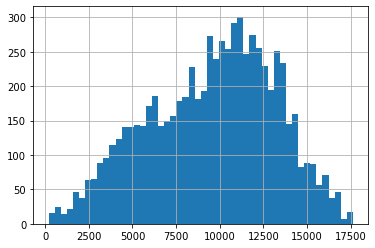

In [45]:
each_wind_year_min_pd.geod_dist_m.hist(bins=50)

In [46]:
each_wind_year_min_pd.to_csv('C:\\Users\\matts\\Google Drive\\berkeley\\.shortcut-targets-by-id\\11wLy1WKwOTcthBs1rpfEzkqax2BZG-6E\\W210_Capstone\\Data\\lookup tables\\wind_grid_to_ps_point_lookup.csv')

# Finished with point sources, now do the same for schools